## Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
%matplotlib inline
import seaborn as sns
from skimage.io import imread
from skimage import img_as_float
import pylab
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings

import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings('ignore')
from numpy import random

from sklearn.cluster import MeanShift
from matplotlib import style
style.use("ggplot")

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (4, 3)

In [2]:
data_xls = pd.read_excel('geo.xlsx', index_col=None)
data_xls.to_csv('geo1.csv', encoding='utf-8')
data = pd.read_csv('geo1.csv')
data.head(20)

,Unnamed: 0,Unnamed: 0.1,x,y,comment_class
0,0,0,37.612416,55.777454,-1
1,1,1,37.612416,55.777454,-1
2,2,2,37.603298,55.742108,-1
3,3,3,37.558526,55.728758,-1
4,4,4,37.566431,55.731794,-1
5,5,5,37.558526,55.728758,-1
6,6,6,37.566431,55.731794,-1
7,7,7,37.558957,55.723399,-1
8,8,8,37.558957,55.723399,-1
9,9,9,37.565767,55.734567,-1


In [3]:
data[data['comment_class']==1].head()

,Unnamed: 0,Unnamed: 0.1,x,y,comment_class
28,28,28,37.588916,55.741982,1
45,45,45,37.589311,55.734273,1
46,46,46,37.558526,55.728758,1
47,47,47,37.566431,55.731794,1
61,61,61,37.589311,55.734273,1


In [4]:
X = data[['x', 'y']]
X = X.to_numpy()
X

array([[37.612416, 55.777454],
       [37.612416, 55.777454],
       [37.603298, 55.742108],
       ...,
       [37.421066, 55.848756],
       [37.448509, 55.793065],
       [37.451249, 55.83662 ]])

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_scaled

array([[ 0.36791896,  0.15955291],
       [ 0.36791896,  0.15955291],
       [ 0.2931784 , -0.34813064],
       ...,
       [-1.20058354,  1.1836816 ],
       [-0.97563233,  0.38377766],
       [-0.95317246,  1.00936916]])

In [7]:
clusters_random = np.random.randint(low=0, high=2, size=len(X))

функция-заготовка для выбора алгоритма

In [125]:
def get_descr(algo_name, y, y_pred, X):
    return "{}\nARI {:.2f}\nSilhouette {:.2f}".format(
        algo_name,
        adjusted_rand_score(y, y_pred),
        silhouette_score(X, y_pred)
    )

проследите за ростом ARI и за падением Silhouette (хотя этот показатель по своему назначению тоже должен расти):

# сразу с выбором алгоритма не работает - подскажите, пожалуйста, почему?

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))
alpha = 0.3
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_random, cmap='autumn', s=60, alpha=alpha)
axes[0].set_title(get_descr("Random", y, clusters_random, X_scaled))
for ax, algorithm in zip(axes[1:], algorithms):
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=60, alpha=alpha)
    ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))
    
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

# Второй вариант - KMeans вручную

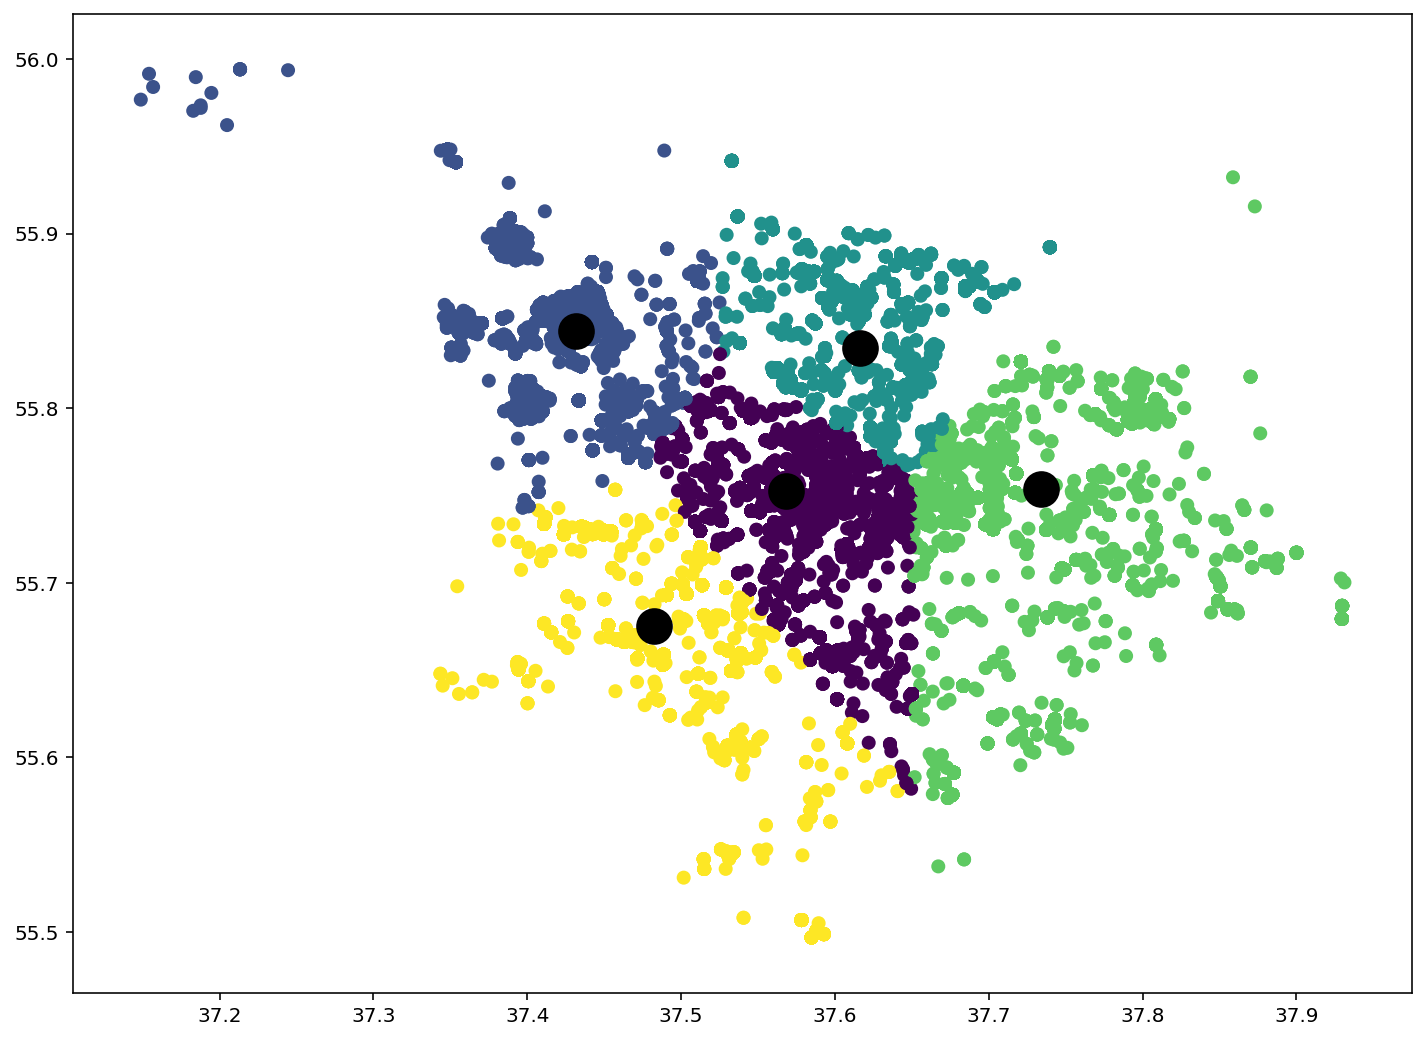

In [140]:
def MyKMeans(X, n_clusters):
             #as_generators=False):
            # случайные точки из массива точек для начала расчета Евклидова расстояния
            #центроид - это случайная подвыборка из наших семплов
            #делаем случайную подвыборку из массива целых чисел от нуля до -1 индекса массива???????чего???
            #почему нужны именно целые?почему по длине массива? каким образом всего 2-3 точки получаем?
    centroids = X[random.choice(list(range(len(X))), n_clusters)]
    #выбираем количество эпох = 100 - это 100 раз выбираем центроид????
    n_epochs = 100
    #начинаем по одной пробегать по эпохам:

    for _ in range(n_epochs):

        #считаем расстояние до кластеров

        belonging = []
    #записываем расстояния от каждого семпла до каждого кластера
        for sample in X:
            distances = []
    #для каждого центра в центроидах находим расстояние
            for center in centroids:
                distance = np.sqrt((sample[0] - center[0])**2 + (sample[1] - center[1])**2)
                distances.append(distance)
            belonging.append(distances)

        #определяем принадлежность кластерам:
        belonging = np.array(belonging)
        belonging = np.argmin(belonging, axis=1)

        #пересчитываем центры - НЕПОНЯТНО!!!!!!
    #пробегаемся по заданному рандомному количеству кластеров и задаем точки,
    #в которых индекс равен одному из номеров кластеров???????зачем?и зачем было сразу в нампи пихать?
        new_centroids = []
        for c in range(n_clusters):
            points = X[belonging==c]
            new_centroids.append(points.mean(axis=0))

        centroids = np.array(new_centroids)
    return belonging, centroids
y_pred, centers = MyKMeans(X, 5)
plt.figure(figsize=(12,9))
plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.scatter(centers[:,0], centers[:,1], c='black', s=300)
plt.show()

# Третий вариант KMeans библиотека

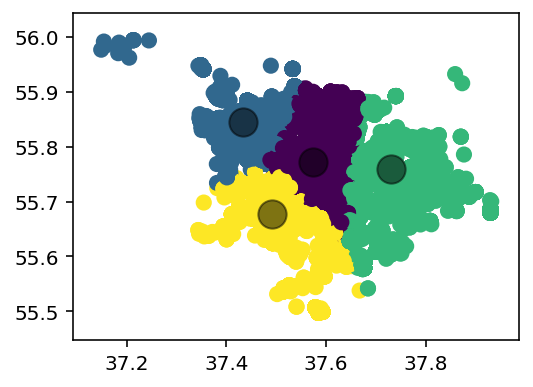

In [17]:
#метод KMeans:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c = y_kmeans, s = 50, cmap = 'viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5);
plt.show()

In [8]:
X

array([[37.612416, 55.777454],
       [37.612416, 55.777454],
       [37.603298, 55.742108],
       ...,
       [37.421066, 55.848756],
       [37.448509, 55.793065],
       [37.451249, 55.83662 ]])

# Задание 2

In [10]:
#Разделим жителей на госоовавших за и против на data1 и data2 соответственно
data1 = data[data['comment_class']==1]
data2 = data[data['comment_class']==-1]
data2.head()

,Unnamed: 0,Unnamed: 0.1,x,y,comment_class
0,0,0,37.612416,55.777454,-1
1,1,1,37.612416,55.777454,-1
2,2,2,37.603298,55.742108,-1
3,3,3,37.558526,55.728758,-1
4,4,4,37.566431,55.731794,-1


In [11]:
X1 = data1[['x', 'y']]
X1 = X1.to_numpy()
X2 = data2[['x', 'y']]
X2 = X2.to_numpy()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_scaled1 = scaler.fit_transform(X1)
X_scaled2 = scaler.fit_transform(X2)

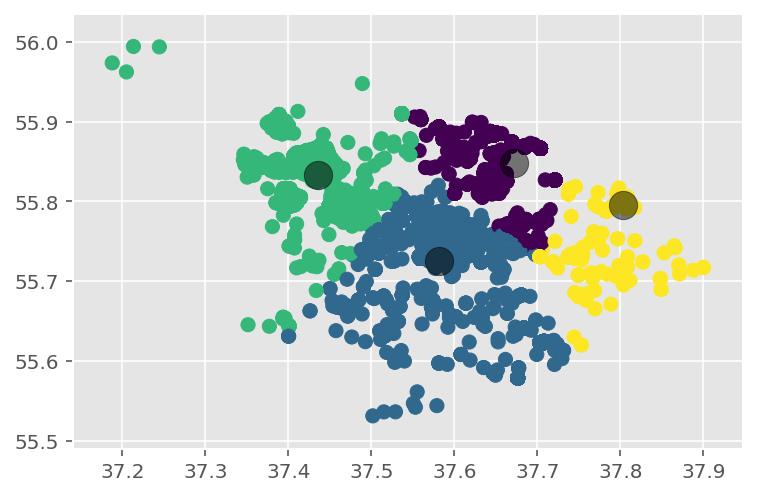

In [12]:
#метод KMeans для "за":
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X1)
y_kmeans = kmeans.predict(X1)
plt.scatter(X1[:, 0], X1[:, 1], c = y_kmeans, s = 50, cmap = 'viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5);
plt.show()

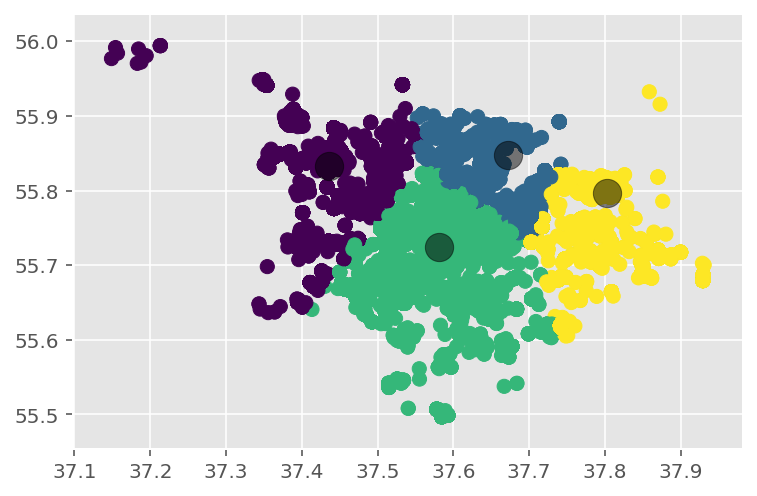

In [13]:
#метод KMeans для "против":
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X1)
y_kmeans = kmeans.predict(X2)
plt.scatter(X2[:, 0], X2[:, 1], c = y_kmeans, s = 50, cmap = 'viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5);
plt.show()

# ЗАДАНИЕ 3

In [137]:

X_scaleds = [X_scaled, X_scaled1, X_scaled2]
k_inertia = []
ks = range(1,11)
for i in X_scaleds:
    
    for k in ks:
        clf_kmeans = KMeans(n_clusters=k)
        #clusters_kmeans = 
        clf_kmeans.fit_predict(X_scaled )
        
        k_inertia.append([clf_kmeans.inertia_, i])


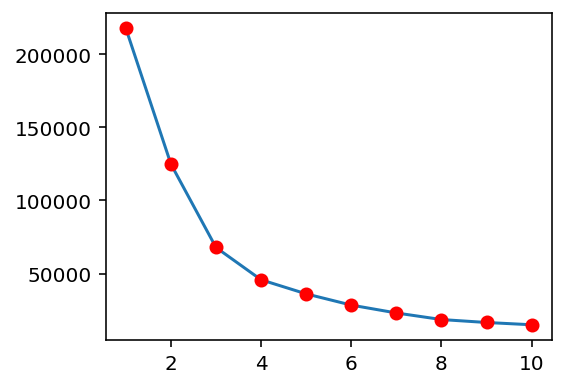

In [117]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

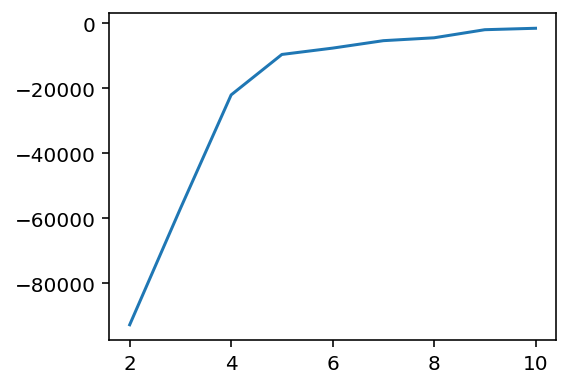

In [112]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

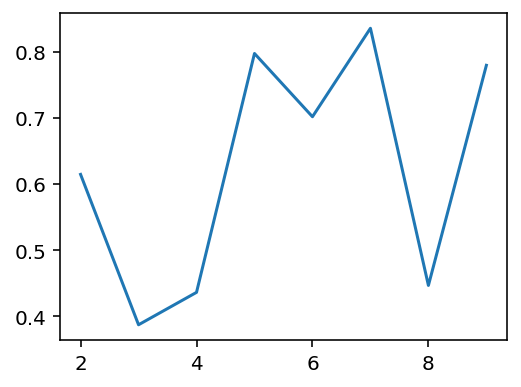

In [113]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [114]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3